In [1]:
import math
import argparse
from glob import glob
from scipy import optimize as opt
import numpy as np
import cv2
import os
from google.colab.patches import cv2_imshow
import torch

In [ ]:
x, y = np.meshgrid(range(9), range(6))

[[0 1 2 3 4 5 6 7 8]
 [0 1 2 3 4 5 6 7 8]
 [0 1 2 3 4 5 6 7 8]
 [0 1 2 3 4 5 6 7 8]
 [0 1 2 3 4 5 6 7 8]
 [0 1 2 3 4 5 6 7 8]]

[[0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1]
 [2 2 2 2 2 2 2 2 2]
 [3 3 3 3 3 3 3 3 3]
 [4 4 4 4 4 4 4 4 4]
 [5 5 5 5 5 5 5 5 5]]


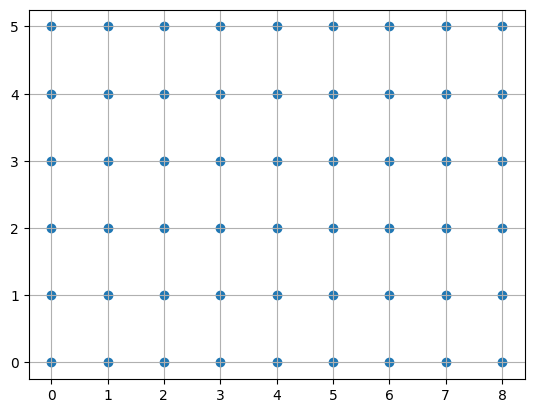

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(x, y)
plt.grid()


In [ ]:
world_points = np.hstack((x.reshape(54, 1), y.reshape(
        54, 1))).astype(np.float32)
print(world_points * 21.5)

In [ ]:
def displayReprojectedPoints(images_points, optimized_points, images):

    for i, (imagepath, image_points, reprojected_points) in enumerate(zip(images, images_points, optimized_points)):
        image = cv2.imread(imagepath) #이미지 read

        for pt, reprojpt in zip(image_points, reprojected_points):
            x, y = int(pt[0]), int(pt[1]) #보정 전 이미지 x,y좌표
            x_rp, y_rp = int(reprojpt[0]), int(reprojpt[1]) #보정 후 이미지 x, y좌표
            cv2.circle(image, (x, y), 15, (255, 0, 0), thickness=5, lineType=8, shift=0) # 보정 전 이미지 x,y 좌표 반지름 15원
            cv2.rectangle(image, (x_rp-5, y_rp-5), (x_rp+5, y_rp+5), (0, 0, 255), thickness=cv2.FILLED) #보정 전 이미지에 사각형 채워넣음

        cv2_imshow(image)
        #cv2.moveWindow("Reprojected", 200, 200)
        cv2.imwrite("Output/{}.jpg".format(i), image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

In [ ]:
def getExtrinsicParams(K, lamda, homography_matrix):
    K_inv = np.linalg.inv(K) #K의 역행렬을 구한다(여기서 K는 intrinsic parameters matrix)

    r1 = np.dot(K_inv, homography_matrix[:, 0]) #K 역행렬과 변환행렬의 첫번째 열 곱셈.
    lamda = np.linalg.norm(r1, ord=2),
    r1 = r1/lamda #정규화

    r2 = np.dot(K_inv, homography_matrix[:, 1])  #K 역행렬과 변환행렬의 두번째 열 곱셈
    r2 = r2/lamda  #정규화

    t = np.dot(K_inv, homography_matrix[:, 2])/lamda #K 역행렬과 변환행렬의 세번째 열 곱셈

    r3 = np.cross(r1, r2) #외적을 통해 z축

    R = np.asarray([r1, r2, r3]) #회전행렬
    R = R.T

    # t = np.array([t])
    # t = t.T

    return R, t #회전행렬과 평행이동행렬


In [ ]:
def optimizationCostFunction(init, lamda, images_points, world_points, homography_matrices): #최소화 해야하는 값
    K = np.zeros(shape=(3, 3)) #초기 매개변수 활용해 init 값 넣기위한 행렬
    K[0, 0], K[1, 1], K[0, 2], K[1, 2], K[0, 1], K[2, 2] = init[0], init[1], init[2], init[3], init[4], 1
    k1, k2 = init[5], init[6] #왜곡계수
    u0, v0 = init[2], init[3] #좌표

    reprojection_error = np.empty(shape=(1404), dtype=np.float64) #투영값 저장위한 array. 702쌍 최적화
    i = 0 #모든 지점에서 변환이 생기기 때문에 homography matrix는 다수 존재
    for image_points, homography_matrix in zip(images_points, homography_matrices):
        R, t = getExtrinsicParams(K, lamda, homography_matrix) #intrinsic parameter와 homography 활용해 R, t(R: 3x3 행렬)

        augment = np.zeros((3, 4))
        augment[:, :-1] = R
        augment[:, -1] = t #augment 행렬에 R, t를 넣어준다.

        for pt, wrldpt in zip(image_points, world_points): # 각 쌍들에 대한 오차 계산
            M = np.array([[wrldpt[0]], [wrldpt[1]], [0], [1]]) #world 좌표게
            ar = np.dot(augment, M) #결과값: 3x1 
            ar = ar/ar[2] # w값으로 나누어준다
            x, y = ar[0], ar[1] #픽셀 좌표계

            U = np.dot(K, ar) 
            U = U/U[2]
            u, v = U[0], U[1] #정규좌표계

            t = x**2 + y**2 #왜곡 반경값          Q. 왜 이값을 이용하는지는 ?
            u_dash = u + (u-u0)*(k1*t + k2*(t**2)) #수정된 값
            v_dash = v + (v-v0)*(k1*t + k2*(t**2))

            reprojection_error[i] = pt[0]-u_dash #각각의 에러값을 넣는다
            i += 1
            reprojection_error[i] = pt[1]-v_dash
            i += 1

    return reprojection_error

In [ ]:
def getReprojectionErrorOptimized(image_points, world_points, A, R, t, k1, k2): #업데이트 된 값 반환
    error = 0
    reprojected_points = []

    augment = np.zeros((3, 4)) #extrinsic parameter
    augment[:, :-1] = R
    augment[:, -1] = t 

    u0, v0 = A[0, 2], A[1, 2] #정규 좌표

    for pt, wrldpt in zip(image_points, world_points):
        M = np.array([[wrldpt[0]], [wrldpt[1]], [0], [1]]) 
        ar = np.dot(augment, M) 
        ar = ar/ar[2]
        x, y = ar[0], ar[1]

        U = np.dot(A, ar)
        U = U/U[2]
        u, v = U[0], U[1]

        t = x**2 + y**2
        u_dash = u + (u-u0)*(k1*t + k2*(t**2))
        v_dash = v + (v-v0)*(k1*t + k2*(t**2))

        reprojected_points.append([u_dash, v_dash])

        error = error + np.sqrt((pt[0]-u_dash)**2 + (pt[1]-v_dash)**2) 

    return error, reprojected_points

In [ ]:
def getReprojectionError(image_points, world_points, A, R, t): #오차계산
    error = 0
    augment = np.zeros((3, 4))
    augment[:, :-1] = R
    augment[:, -1] = t

    N = np.dot(A, augment)

    for pt, wrldpt in zip(image_points, world_points):
        M = np.array([[wrldpt[0]], [wrldpt[1]], [0], [1]]) #world point
        realpt = np.array([[pt[0]], [pt[1]], [1]]) #image point
        projpt = np.dot(N, M) # 투영된 이미지
        projpt = projpt/projpt[2]
        diff = realpt - projpt
        error = error + np.linalg.norm(diff, ord=2) #에러계산. l2 norm사용

    return error


In [ ]:
def getCalibMatrix(b):  #calibration matrix구하는 함수
  #b : 투영행렬(projection matrix)
    v = (b[0][1]*b[0][3] - b[0][0]*b[0][4])/(b[0][0]*b[0][2] - b[0][1]**2)
    lamda = b[0][5] - (b[0][3]**2 +
                       v*(b[0][1]*b[0][3] - b[0][0]*b[0][4]))/b[0][0]
    fx = math.sqrt(lamda/b[0][0])
    fy = math.sqrt(lamda*b[0][0]/(b[0][0]*b[0][2] - b[0][1]**2))
    skew = (-1*b[0][1]*fx**2*fy)/(lamda)
    u = (skew*v)/fy - (b[0][3]*fx**2)/lamda

    print("u = {}\nv = {}\nlamda = {}\nfx = {}\nfy = {}\nskew = {}\n".format(
        u, v, lamda, fx, fy, skew))

    K = np.array([[fx, skew, u], [0, fy, v], [0, 0, 1]])
    return K, lamda 


In [ ]:
def getBMatrix(V):
    _, _, vh = np.linalg.svd(V, full_matrices=True)
    #  Vb = 0 #자료 43페이지 ~ 45페이지
    b = vh[-1:]
    return b


In [ ]:
def updateVMatrix(H, V): #자료 42p
    v_12 = [H[0][0]*H[0][1], (H[0][0]*H[1][1] + H[1][0]*H[0][1]), H[1][0]*H[1][1],
            (H[2][0]*H[0][1] + H[0][0]*H[2][1]), (H[2][0]*H[1][1] + H[1][0]*H[2][1]), H[2][0]*H[2][1]]

    # print v_12
    # v11 - v22 한번에 계산
    trm1 = H[0][0]*H[0][0] - H[0][1]*H[0][1]
    trm2 = 2*(H[0][0]*H[1][0] - H[0][1]*H[1][1])
    trm3 = H[1][0]*H[1][0] - H[1][1]*H[1][1]
    trm4 = 2*(H[2][0]*H[0][0] - H[0][1]*H[2][1])
    trm5 = 2*(H[2][0]*H[1][0] - H[1][1]*H[2][1])
    trm6 = H[2][0]*H[2][0] - H[2][1]*H[2][1]

    v_1122 = []
    v_1122.append(trm1)
    v_1122.append(trm2)
    v_1122.append(trm3)
    v_1122.append(trm4)
    v_1122.append(trm5)
    v_1122.append(trm6)

    # print v_1122

    V.append(v_12)
    V.append(v_1122)

    # print V
    # print "\n \n"


In [ ]:
def computeHomography(corners, world_points):
    src = np.asarray(world_points)
    dst = np.asarray(corners)

    homography, _ = cv2.findHomography(src, dst) #_ 값은 mask값. 여기서는 별로 필요없는듯?
    
    
    #n = 20
    #src = np.asarray(world_points[: n])  # world
    #dst = np.asarray(corners[: n])  # image
   
    #P = np.zeros((2*n, 9)) # homography는 3x3행렬이므로

    #i = 0
    #for (srcpt, dstpt) in zip(src, dst):
        #x, y, x_dash, y_dash = srcpt[0], srcpt[1], dstpt[0], dstpt[1]

        #P[i][0], P[i][1], P[i][2] = -x, -y, -1 #자료 21p
        #P[i+1][0], P[i+1][1], P[i+1][2] = 0, 0, 0

        #P[i][3], P[i][4], P[i][5] = 0, 0, 0  
        #P[i+1][3], P[i+1][4], P[i+1][5] = -x, -y, -1

        #P[i][6], P[i][7], P[i][8] = x*x_dash, y*x_dash, x_dash
        #P[i+1][6], P[i+1][7], P[i+1][8] = x*y_dash, y*y_dash, y_dash

        #i = i+2

    #_, _, vh = np.linalg.svd(P, full_matrices=True) #Direct Linear transform  #환기님 자료  23p
    #h = vh[-1:] #마지막 행만 추출 이유는..?
    #h.resize((3, 3))

    #homography = h/h[2, 2]

    return homography


In [ ]:
a = torch.rand(2, 5)

print(a)
print(a[-1:])

tensor([[0.1688, 0.3858, 0.4869, 0.1200, 0.9518],
        [0.4054, 0.9789, 0.7842, 0.6088, 0.4064]])
tensor([[0.4054, 0.9789, 0.7842, 0.6088, 0.4064]])


In [2]:
image_path = []
dir_path = '/content/drive/MyDrive/Calibration_Imgs/Calibration_Imgs/'
images = os.listdir(dir_path)
for image in images:
  image_path.append(os.path.join(dir_path, image))

In [5]:
image = image_path[1]
image = cv2.imread(image)

ret, corners = cv2.findChessboardCorners(image, (9, 6), None)

In [ ]:
print(ret)
print(corners.shape)
gray = cv2.drawChessboardCorners(image, (9,6), corners, ret)
cv2_imshow(gray)

In [ ]:
V = []

x, y = np.meshgrid(range(9), range(6)) #world point격자 생성(체스보드는 2D로 보기때문에 2D 월드좌표계)
world_points = np.hstack((x.reshape(54, 1), y.reshape(54, 1))).astype(np.float32)  #(x,y)좌표 쌍 생성
world_points = world_points*21.5 # rectangular size 21.5를 곱해 실제 체스보드처럼
world_points = np.asarray(world_points)

images_points = []
homography_matrices = []

for imagepath in image_path:
  image = cv2.imread(imagepath)
  #scale_percent = 0.3  # 변환시킬 수도 있음
  #height = int(image.shape[0] * scale_percent)
  #width = int(image.shape[1] * scale_percent)
  #dim = (width, height)

  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #변환하지 않아도 되지만 약간의 연산량 차이가 날수도?

  ret, corners = cv2.findChessboardCorners(gray, (9, 6), None) # ret: 찾을 수 있다면 True or False, 
        # opencv 함수활용해 코너 찾는다
  if ret == True:
    corners = corners.reshape(-1, 2)
    #gray = cv2.drawChessboardCorners(gray, (9, 6), corners, ret)
        
    homography_matrix = computeHomography(corners, world_points) #corner, world point활용해 homography 행렬

    images_points.append(corners)
    homography_matrices.append(homography_matrix)
    
    updateVMatrix(homography_matrix, V)
    #cv2_imshow(gray)
    #cv2.waitKey(500)

    #cv2.destroyAllWindows()
V = np.asarray(V)
b = getBMatrix(V)

K, lamda = getCalibMatrix(b)

error = 0

for image_points, homograph_matrix in zip(images_points, homography_matrices):
  R, t = getExtrinsicParams(K, lamda, homography_matrix) #extrinsic parameter 구하기

  reprojection_error = getReprojectionError(image_points, world_points, K, R, t)

  error +=  reprojection_error #에러계산

error /= (13*9*6)

print('ERROR : {}'.format(error))

init = [K[0, 0], K[1, 1], K[0, 2], K[1, 2], K[0, 1], 0, 0] #(0, 0)은 왜곡계수, 그러나여기서는 0가정
res = opt.least_squares(fun = optimizationCostFunction, x0 = init, method = 'lm', 
                        args = [lamda, images_points, world_points, homography_matrices])

K_opt = np.zeros(shape = (3, 3))
K_opt[0, 0], K_opt[1, 1], K_opt[0, 2], K_opt[1, 2], K_opt[0, 1], K_opt[2, 2] = res.x[0], res.x[1], res.x[2], res.x[3], res.x[4], 1
#최적화
k1_opt, k2_opt = res.x[5], res.x[6]

print('CALIBRATION MATRIX AFTER OPTIMIZATION : {}'.format(K_opt))
print('DISTIORTION COEFFICIENT AFTER OPTIMIZATION : {}'.format(k1_opt, k2_opt))

error_opt = 0
optimized_points = []
for image_points, homography_matrix in zip(images_points, homography_matrices):
  R, t = getExtrinsicParams(K_opt, lamda, homography_matrix)

  reprojection_error, reprojected_points = getReprojectionErrorOptimized(image_points, world_points, K_opt, R, t, k1_opt, k2_opt)
  optimized_points.append(reprojected_points)

  error_opt = error_opt + reprojection_error

error_opt = error_opt/(13*9*6)
print("\nMean Reprojection error after optimization: \n{}".format(error_opt[0]))

displayReprojectedPoints(images_points, optimized_points, image_path)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
for imagepath in image_path:
    image = cv2.imread(imagepath)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
    if ret == True:
        corners = corners.reshape(-1, 2)
        gray = cv2.drawChessboardCorners(gray, (9, 6), corners, ret)

        # Increase the circle size and line thickness for better visibility
        for corner in corners:
            x, y = corner.ravel().astype(int)
            cv2.circle(gray, (x, y), 5, (0, 255, 0), -1)

        cv2_imshow(gray)
        cv2.waitKey(500)

cv2.destroyAllWindows()

Output hidden; open in https://colab.research.google.com to view.